In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

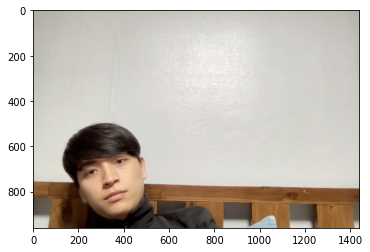

In [3]:
#사진 불러오기
my_image_path = './images/img3.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### cv2.imread(img_path, flag)
이미지 파일을 flag값에 따라서 읽어들입니다.
- cv2.IMREAD_COLOR : 이미지 파일을 Color로 읽어들입니다. 투명한 부분은 무시되며, Default값입니다.
- cv2.IMREAD_GRAYSCALE : 이미지를 Grayscale로 읽어 들입니다. 실제 이미지 처리시 중간단계로 많이 사용합니다.
- cv2.IMREAD_UNCHANGED : 이미지파일을 alpha channel까지 포함하여 읽어 들입니다.

3개의 flag대신에 1, 0, -1을 사용해도 됩니다.

In [4]:
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

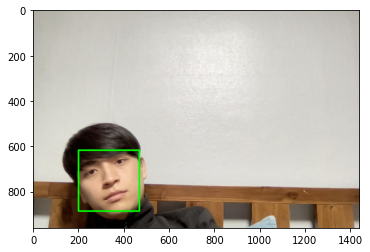

In [5]:
#얼굴 검출 face detection
detector_hog = dlib.get_frontal_face_detector()

dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 5, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [6]:
#모델 불러오기
model_path = './models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [7]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

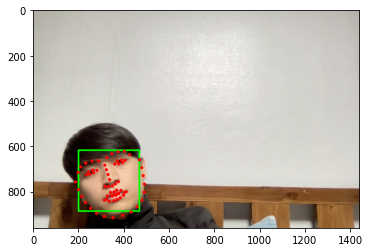

In [8]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 7, (0, 0, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [31]:
#스티커 위치 구하기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(337, 746)
(x,y) : (337,612)
(w,h) : (269,269)


In [41]:
#스티커 적용
sticker_path = './images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(269, 269, 3)


In [42]:
refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

#음수 좌표 처리
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (203,343)
(x,y) : (203,343)


In [43]:
#스티커 적용
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

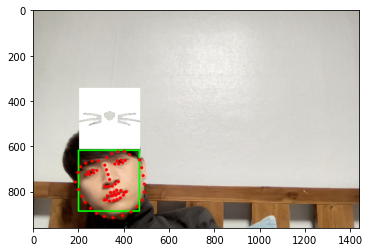

In [44]:
#결과 확인
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

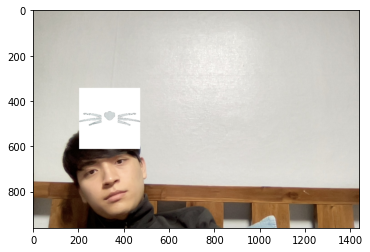

In [45]:
#결과 출력
sticker_area = img_rgb[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

---
# 회고
